In [1]:
import sympy
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from sympy.functions.special.polynomials import chebyshevt
from scipy.stats import norm
from qiskit.circuit.library import PolynomialPauliRotations
from qiskit.visualization import plot_histogram
from qiskit_algorithms import IterativeAmplitudeEstimation,EstimationProblem

In [26]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
#backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
sampler = Sampler(mode=backend)

# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

We are using the ibm_torino quantum computer


In [3]:
try:
    # Input
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # Define the symbols
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # Parse the Function String
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # VALIDATE
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")


Entered definite integral Mathematical expression:


9      
⌠      
⎮  2   
⎮ x  dx
⌡      
0      

In [4]:
def getChebyshevPolynomial( sympy_symbol,sympy_func ,degree, lower_limit, upper_limit):
    """
    Generates a high-quality Chebyshev polynomial approximation for a given SymPy function
    using NumPy's fitting method.
    This is the ideal method because Taylor's approximation requires O(d^2) oracle calls.
    Chebyshev approximation also uniformly distributes the error in the range making it ideal for this scenario.
    """
    print(f"Chebyshev Approximation to {degree}th degree:\n")

    # 1. Callable numerical version of the function "Oracle"
    f_numeric = sympy.lambdify(sympy_symbol, sympy_func, 'numpy')

    # 2. Define the coordinate transformation from [lower_limit, upper_limit] to [-1, 1]
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This is f(x) re-parameterized in terms of y. This is the function we will approximate.
    func_to_approximate = lambda y_val: f_numeric(jac_scaling * y_val + offset)

    # 3. Generate sample points and query the oracle to get data for fitting
    # For a degree `d` polynomial, we need at least `d+1` points. 2*degree is ideal
    num_samples = 2 * degree
    sample_points_y = np.linspace(-1, 1, num_samples)
    sample_values_f = func_to_approximate(sample_points_y)

    # 4. Use NumPy to fit the Chebyshev polynomial to the sampled data
    cheb_poly_fit = np.polynomial.chebyshev.Chebyshev.fit(
        sample_points_y,
        sample_values_f,
        deg=degree
    )
    
    # The coefficients are ordered from T_0 to T_d
    coeffs = cheb_poly_fit.convert().coef
    print(f"Found {len(coeffs)} coefficients.")

    # 5. Calculate the scaling factor M = max(|f(x)|)
    # We find the max value by evaluating our new high-quality approximation on a fine grid.
    fine_grid_y = np.linspace(-1, 1, 1000)
    interpolation_f =(cheb_poly_fit(fine_grid_y))
    m= np.min(interpolation_f)
    M = np.max(interpolation_f)
    print(f"M value for scaling is: {M:.4f}")

    # 6. Reconstruct a SymPy expression for display and symbolic integration
    # The polynomial for the integral must approximate g(y) = f(x) * jac_scaling
    y_sym = sympy.Symbol('y')
    chebyshev_sympy_f = sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))
    chebyshev_sympy_g = jac_scaling * chebyshev_sympy_f

    integration_expr = sympy.Integral(chebyshev_sympy_g, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)
    
    # 7. New: Explicitly check the endpoint error to verify the quality
    true_val_at_endpoint = func_to_approximate(1.0) # This is f(upper_limit)
    approx_val_at_endpoint = cheb_poly_fit(1.0)
    abs_error = np.abs(true_val_at_endpoint - approx_val_at_endpoint)
    
    print(f"\nError analysis at endpoint y=1 (x={upper_limit}):")
    print(f"  - True value of f({upper_limit}) = {true_val_at_endpoint:.8f}")
    print(f"  - Approx value from poly = {approx_val_at_endpoint:.8f}")
    print(f"  - Absolute Error = {abs_error:.2e}")

    return coeffs,m ,M, chebyshev_sympy_g

In [5]:
def extract_quantum_coefficients(coeffs, m, M, n_qubits):
    """
    Extract coefficients for quantum state preparation from Chebyshev approximation.
    
    Parameters:
    -----------
    coeffs : array-like
        Chebyshev polynomial coefficients from your approximation
    m : float
        Minimum value of the function
    M : float
        Maximum value of the function
    n_qubits : int
        Number of qubits for the quantum state
    
    Returns:
    --------
    theta_coeffs : list
        Coefficients for θ(i) polynomial where i ∈ [0, 2^n - 1]
    scaling_info : dict
        Information about the scaling applied
    """
    
    # Number of basis states
    N = 2**n_qubits
    
    # Step 1: Scale the Chebyshev polynomial to have range [0, 1]
    # If f(x) has range [m, M], then (f(x) - m)/(M - m) has range [0, 1]
    range_scale = M - m
    if range_scale == 0:
        raise ValueError("Function has constant value, cannot scale")
    
    # Adjust coefficients for the vertical scaling
    # The constant term needs special handling
    scaled_coeffs = coeffs.copy()
    scaled_coeffs[0] = (coeffs[0] - m) / range_scale
    for i in range(1, len(coeffs)):
        scaled_coeffs[i] = coeffs[i] / range_scale
    
    print(f"Scaling from range [{m:.4f}, {M:.4f}] to [0, 1]")
    print(f"Scaled Chebyshev coefficients: {scaled_coeffs[:5]}...")  # Show first 5
    
    # Step 2: Convert from Chebyshev basis to standard polynomial basis
    # We need to express the polynomial in terms of i where i ∈ [0, N-1]
    # First, map i → y where y ∈ [-1, 1]: y = 2*i/(N-1) - 1
    
    # Create symbolic variable
    i_sym = sympy.symbols('i')
    y_sym = 2*i_sym/(N-1) - 1
    
    # Build the Chebyshev polynomial in terms of i
    poly_expr = sum(scaled_coeffs[k] * chebyshevt(k, y_sym) for k in range(len(scaled_coeffs)))
    
    # Expand to get standard polynomial coefficients
    poly_expanded = sympy.expand(poly_expr)
    poly_collected = sympy.collect(poly_expanded, i_sym)
    
    # Extract coefficients of powers of i
    degree = len(scaled_coeffs) - 1
    theta_coeffs = []
    
    for power in range(degree + 1):
        coeff = poly_collected.coeff(i_sym, power)
        if coeff is None:
            theta_coeffs.append(0.0)
        else:
            theta_coeffs.append(float(coeff))
    
    print(f"\nExtracted polynomial coefficients for θ(i):")
    print(f"Degree: {degree}")
    print(f"First few coefficients: {theta_coeffs[:min(5, len(theta_coeffs))]}")
    
    # Step 3: Verification (optional but recommended)
    # Check a few sample points to ensure correctness
    print("\nVerification at sample points:")
    sample_indices = [0, N//4, N//2, 3*N//4, N-1]
    
    # Create numerical function for θ(i)
    theta_func = lambda idx: sum(theta_coeffs[k] * idx**k for k in range(len(theta_coeffs)))
    
    for idx in sample_indices[:3]:  # Check first 3 samples
        y_val = 2*idx/(N-1) - 1
        # Evaluate original scaled Chebyshev at this point
        cheby_val = sum(scaled_coeffs[k] * float(chebyshevt(k, y_val).evalf()) 
                       for k in range(len(scaled_coeffs)))
        poly_val = theta_func(idx)
        print(f"  i={idx}: Chebyshev={cheby_val:.6f}, Polynomial={poly_val:.6f}, "
              f"Error={abs(cheby_val - poly_val):.2e}")
    
    # Step 4: Prepare for quantum circuit
    # For PolynomialPauliRotations, we need rotation angles
    # The rotation angle is 2*arcsin(sqrt(amplitude))
    # So we need θ(i) such that amplitude_i = sin²(θ(i)/2)
    
    # Therefore, θ(i) = 2*arcsin(sqrt(f_scaled(i)))
    # This requires another transformation if you want direct amplitude encoding
    
    scaling_info = {
        'original_range': (m, M),
        'scaled_range': (0, 1),
        'n_qubits': n_qubits,
        'n_states': N,
        'degree': degree,
        'domain_mapping': 'i ∈ [0, 2^n - 1] → y ∈ [-1, 1]'
    }
    
    return theta_coeffs, scaling_info

In [6]:
def get_rotation_polynomial(scaled_poly_coeffs, n_qubits, degree):
    """
    Approximates the angle function 2*arcsin(sqrt(p(i))) with a new polynomial.
    """
    N = 2**n_qubits
    
    # 1. Create a callable function for the scaled polynomial p_scaled(i)
    p_scaled = np.polynomial.Polynomial(scaled_poly_coeffs)

    # 2. Define the target angle function h(i)
    def h(i):
        val = p_scaled(i)
        val = np.clip(val, 0, 1) # Ensure value is in the valid domain for sqrt
        return 2 * np.arcsin(np.sqrt(val))

    # 3. Approximate h(i) with a new polynomial p_rot(i)
    #    (Using the logic from your getChebyshevPolynomial function)
    
    # a. Sample h(i) at Chebyshev nodes over the domain [0, N-1]
    #    Map [0, N-1] to [-1, 1] for sampling
    y_nodes = np.polynomial.chebyshev.chebpts1(2 * degree)
    i_nodes = 0.5 * (y_nodes + 1) * (N - 1)
    
    h_values = h(i_nodes)
    
    # b. Fit a new Chebyshev polynomial to these samples
    cheb_fit_rot = np.polynomial.chebyshev.Chebyshev.fit(y_nodes, h_values, deg=degree)
    
    # c. Convert the fit to a power polynomial for the domain [0, N-1]
    #    This requires the symbolic change-of-variables step you already wrote!
    i_sym = sympy.symbols('i')
    y_sym_map = 2*i_sym/(N-1) - 1
    
    # Reconstruct cheb series in sympy and substitute
    poly_expr = sum(cheb_fit_rot.coef[k] * sympy.chebyshevt(k, y_sym_map) for k in range(degree + 1))
    expanded_poly = sympy.expand(poly_expr)
    
    p_rot = sympy.Poly(expanded_poly, i_sym)
    p_rot_coeffs = [float(c) for c in p_rot.all_coeffs()]
    p_rot_coeffs.reverse() # Ensure lowest degree is first

    return p_rot_coeffs

In [27]:
# Degree of Approximation
d= 8
num_qubits=5
N=2**num_qubits

In [29]:
# Plot an unscaled approximated polyomial to show that the approximated graph is very close to the original.
# Also Plot the |f(x)-P(x)| graph to show that the error is uniformly distributed.
### NOTE: Here g(y) is returned. g(y)= f(x)* jac_scaling.  f(x)= g(y)/jac_scaling
#  jac_scaling=(upper-lower)/2
# Thi existing code
coeffs, m, M, chebyshev_Polynomial = getChebyshevPolynomial(x, func,14, lower_limit, upper_limit)

theta_coeffs, scaling_info = extract_quantum_coefficients(coeffs, m, M, num_qubits)
final_qiskit_coeffs = get_rotation_polynomial(theta_coeffs, num_qubits, d)



Chebyshev Approximation to 14th degree:

Found 15 coefficients.
M value for scaling is: 81.0000

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                      14                         13                        ↪
⎮  ⎝1.38113290002224e-10⋅y   - 3.35283599956539e-10⋅y   - 3.62760900084677e-10 ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪   12                        11                         10                    ↪
↪ ⋅y   + 1.11562720383007e-9⋅y   + 3.06961528840296e-10⋅y   - 1.43670194576078 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         


Error analysis at endpoint y=1 (x=9.0):
  - True value of f(9.0) = 81.00000000
  - Approx value from poly = 81.00000000
  - Absolute Error = 0.00e+00
Scaling from range [-0.0000, 81.0000] to [0, 1]
Scaled Chebyshev coefficients: [ 0.375  0.5    0.125  0.    -0.   ]...

Extracted polynomial coefficients for θ(i):
Degree: 14
First few coefficients: [9.063019797097049e-17, -4.305042496622933e-15, 0.0010405827263343871, -5.318743852287304e-15, 1.9582510191076094e-15]

Verification at sample points:
  i=0: Chebyshev=0.000000, Polynomial=0.000000, Error=4.32e-17
  i=8: Chebyshev=0.066597, Polynomial=0.066597, Error=1.39e-17
  i=16: Chebyshev=0.266389, Polynomial=0.266389, Error=2.22e-16


In [30]:
print("Final qiskit coeffs:")
print(final_qiskit_coeffs)
print(len(final_qiskit_coeffs))

Final qiskit coeffs:
[0.008321928775750997, 0.04223686809867777, 0.01763438463235767, -0.005178549185229284, 0.0007375984260905202, -5.634547374116815e-05, 2.3681745073318086e-06, -5.156046074222573e-08, 4.5460977473494954e-10]
9


In [31]:
# Discretize func_expr
def GenerateSamples(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x).
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [32]:



# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= GenerateSamples(f_ideal_callable,-1,1,N)


g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              chebyshev_Polynomial, 'numpy')

# gy_classical= f(x)/jac_scaling
jac_scaling = (upper_limit - lower_limit) / 2.0
y_classical= g_numerical(x_array)/jac_scaling

In [33]:
def IntegrateClassical(y_classical,lower_limit,upper_limit,N):

    total_sum= np.sum(y_classical)

    # Average
    answer=(total_sum/N)*((upper_limit-lower_limit))

    print("Y Classical Array:")
    print(y_classical)


    print("\nClassical Integration Answer:")
    print(answer)
    return

IntegrateClassical(y_classical,lower_limit,upper_limit,N)


Y Classical Array:
[17.80367782 42.83515647 29.74040836 60.00910883  0.2730997   9.7685322
 51.654609    8.24691708 71.29223635 19.66894321 46.50462272 68.8519562
 61.99696667 68.69679557  5.12744512  4.71538314 26.23825278  4.54558871
 20.67345154  2.37435391 61.26203503  0.54005421  0.32191583  4.3772231
 17.19207179 11.65129043  0.00561026 20.44761081 37.3989998   0.794021
 50.21096709 28.61395259]

Classical Integration Answer:
240.14060361198395


The Original Function F_callable is assumed to be the ideal in N samples to show almost continuous function plot.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.

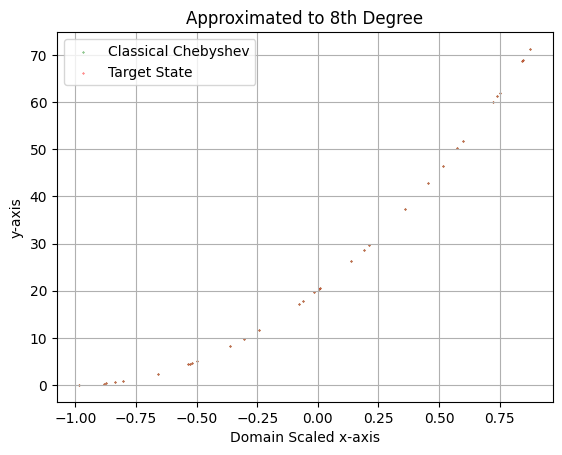

In [34]:
plt.xlabel("Domain Scaled x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

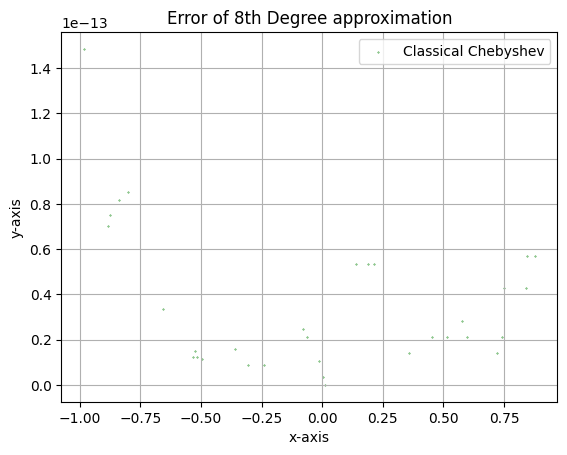

In [35]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of {d}th Degree approximation")
plt.scatter(x_array,np.abs(y_classical-y),
             color='green', label='Classical Chebyshev',s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [36]:
# Prepare the oracle for loading basis states Coeffs.
polyOracle = PolynomialPauliRotations(
    num_state_qubits=num_qubits,
    coeffs=final_qiskit_coeffs,
    basis='Y',name='A_P(x)'
)

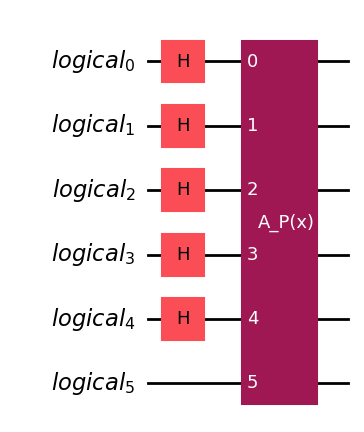

In [37]:
Qbit= QuantumRegister(num_qubits+1,name='logical')
#C_anc= ClassicalRegister(1,name='F_anc')
qc= QuantumCircuit(Qbit)

for i in range(num_qubits):
    qc.h(Qbit[i])

qc.append(polyOracle,Qbit)
#qc.barrier(Qbit)        

qc.draw(output='mpl')

In [41]:
def RunIQAE(qc,epsilon_target,alpha,num_qubits):

    problem = EstimationProblem(
        state_preparation=qc,
        objective_qubits=[num_qubits]  # List of indices for ancilla qubits
    )

    iqae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon_target,
        alpha=alpha,
        sampler=sampler,
        transpiler=pm
    )

    # Run the algorithm on the problem
    result = iqae.estimate(problem)

    return result

In [42]:
# Set desired precision (epsilon) and confidence level (alpha).
epsilon_target = 0.01  # Target precision (1% absolute error)
alpha = 0.05           # Confidence level (1 - alpha = 95% confidence)

# Run the algorithm on the problem
print("--- Running Iterative Amplitude Estimation ---")
result = RunIQAE(qc,epsilon_target,alpha,num_qubits)


print("-" * 50)

print("--- IQAE Results ---")
print(f"Target Precision (epsilon): {epsilon_target}")
print(f"Confidence Level (1 - alpha): {1 -alpha}")
print("-" * 20)
# The final estimated probability 'a'
print(f"🎯 Estimated Probability (a): {result.estimation_processed:.6f}")
# The confidence interval for the true value of 'a'
print(f"Confidence Interval: [{result.confidence_interval_processed[0]:.6f}, {result.confidence_interval_processed[1]:.6f}]")
print(f"Total Oracle Queries: {result.num_oracle_queries}")
print("-" * 50)

QuantumQueries=result.num_oracle_queries
# Un-Scale the scaled function
Quantum_Integral_value=result.estimation_processed*(upper_limit-lower_limit)*(float(M)-float(m))  +float(m)
print(f"The Quantum Integration value: {Quantum_Integral_value}")

--- Running Iterative Amplitude Estimation ---


KeyError: 'shots'

In [19]:
# Number of classical queries is the number of samples generated
def calculate_classical_samples(epsilon_target, alpha):
    """
    Calculates the number of classical samples needed to achieve a target error
    epsilon with a confidence level of (1 - alpha).
    """
    if not 0 < epsilon_target:
        raise ValueError("Epsilon must be a positive number.")
    if not 0 < alpha < 1:
        raise ValueError("Alpha must be between 0 and 1.")
        
    # 1. Find the Z-score for the given confidence level alpha.
    # For a two-sided interval, we look at the 1 - alpha/2 percentile.
    z_score = norm.ppf(1 - alpha / 2)
    
    # 2. Assume worst-case variance (a=0.5) for a standardized comparison.
    # The variance of a Bernoulli trial is a*(1-a), which is max at a=0.5.
    worst_case_variance = 0.25
    
    # 3. Use the full formula: M = z^2 * variance / epsilon^2
    num_samples = (z_score**2 * worst_case_variance) / (epsilon_target**2)
    
    required_samples = int(np.ceil(num_samples))
    
    print(f"For epsilon={epsilon_target} and alpha={alpha} (a {100*(1-alpha):.0f}% confidence level):")
    print(f"Required classical samples: {required_samples}")
    
    return required_samples

In [ ]:
# Create Even logarithmic spaced points for good quadratic plot display. Start from 0.1 to 0.003
# The system crashes for 0.001. Classical Can't simulate for epsilon=0.001. 
# Simulation worked until Epsilon= 0.027
epsilon_targets_array = np.logspace(-1, -2.3, num=12)

print("Target Epsilons array:")
print(epsilon_targets_array)

ClassicalQueries_Array=[]
QuantumQueries_Array=[]
i=1
for epsilon in epsilon_targets_array:

    print(f"Round {i}")

    current=calculate_classical_samples(epsilon,alpha)
    ClassicalQueries_Array.append(current)

    quantumResult= RunIQAE(qc,epsilon,alpha,num_qubits)
    Qcurrent= quantumResult.num_oracle_queries
    print(f"Required Quantum samples: {Qcurrent}")
    QuantumQueries_Array.append(Qcurrent)

    i+=1


Target Epsilons array:
[0.1        0.07459802 0.05564864 0.04151278 0.03096771 0.0231013
 0.01723311 0.01285556 0.00958999 0.00715394 0.0053367  0.00398107]
Round 1
For epsilon=0.1 and alpha=0.05 (a 95% confidence level):
Required classical samples: 97
Required Quantum samples: 0
Round 2
For epsilon=0.07459801523487937 and alpha=0.05 (a 95% confidence level):
Required classical samples: 173
Required Quantum samples: 0
Round 3
For epsilon=0.05564863876983295 and alpha=0.05 (a 95% confidence level):
Required classical samples: 311
Required Quantum samples: 0
Round 4
For epsilon=0.04151278002752295 and alpha=0.05 (a 95% confidence level):
Required classical samples: 558
Required Quantum samples: 0
Round 5
For epsilon=0.03096770996935353 and alpha=0.05 (a 95% confidence level):
Required classical samples: 1002
Required Quantum samples: 5120
Round 6
For epsilon=0.023101297000831605 and alpha=0.05 (a 95% confidence level):
Required classical samples: 1800
Required Quantum samples: 5120
Round

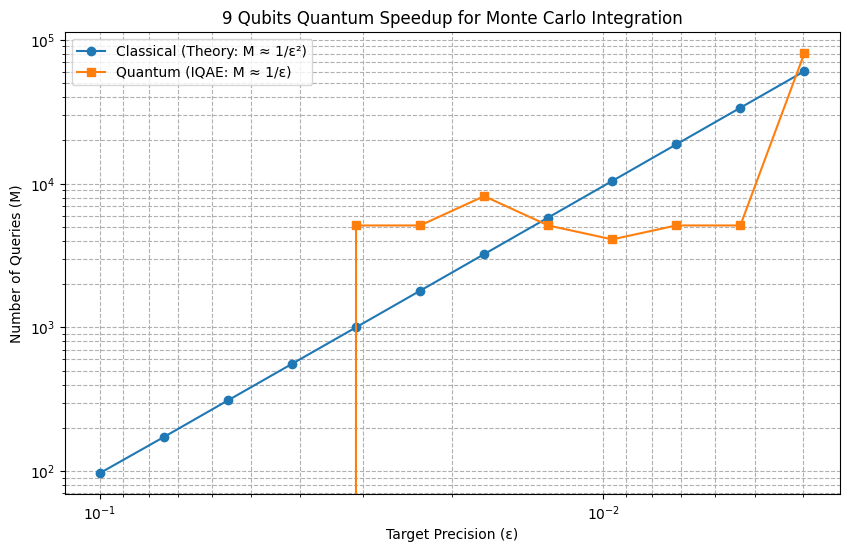

In [25]:
plt.figure(figsize=(10, 6))

# Plot the data on a log-log scale
plt.loglog(epsilon_targets_array, ClassicalQueries_Array, 'o-', label='Classical (Theory: M ≈ 1/ε²)')
plt.loglog(epsilon_targets_array, QuantumQueries_Array, 's-', label='Quantum (IQAE: M ≈ 1/ε)')

plt.title(f"{num_qubits} Qubits Quantum Speedup for Monte Carlo Integration")
plt.xlabel('Target Precision (ε)')
plt.ylabel('Number of Queries (M)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.gca().invert_xaxis()  # Invert x-axis so precision increases to the right
plt.show()